# HamilToniQ: 
# Comprehensive Optimization and Benchmarking for Mixer Hamiltonian in QAOA with Error Mitigation


## Introduction:

Quantum computing, with its potential to solve certain problems exponentially faster than classical computers, has been the subject of intense research and development. One promising application of quantum computing lies in optimization problems, which are ubiquitous in various fields such as logistics, finance, and machine learning. However, solving these problems on a quantum computer poses significant challenges due to the nascent stage of quantum hardware and the complexity of quantum algorithms.

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical algorithm that has been proposed as a practical method to solve combinatorial optimization problems on near-term, noisy intermediate-scale quantum (NISQ) devices. QAOA operates by approximating the ground state of a problem Hamiltonian \(H_P\), which encodes the optimization problem to be solved. The QAOA ansatz state is given by:

\begin{equation}
    |\psi(\beta, \gamma)\rangle = U(\beta, \gamma)|s\rangle,
\end{equation}

where $|\psi\rangle$ is the initial state, and $U(\beta, \gamma)$ is the QAOA unitary. Despite its potential, the performance of QAOA and the mechanisms underlying its success are not yet fully understood.

In this paper, we present a comprehensive study of QAOA, focusing on its performance, the mechanism of its operation, and its implementation on near-term quantum devices. We provide a detailed analysis of the algorithm's performance on different problem instances and investigate the role of quantum interference in the success of QAOA. Furthermore, we discuss practical considerations for implementing QAOA on current quantum hardware, including the impact of noise and the choice of initial states.

Our findings contribute to the understanding of QAOA and provide valuable insights for its application on near-term quantum devices. We hope that our work will guide future research in this area and facilitate the practical use of quantum computing for optimization problems.




### Description of QAOA

add here

### Applications in portfolio optimization
QAOA aims to minimize the expectation value of a cost function. Classically, this function is given by \cite{QAOA2021}
\begin{equation}
    F(z_1, z_2, ..., z_n) = q \sum_{i, j = 1}^n z_i z_j \sigma_{ij} - (1 - q) \sum_{i = 1}^n z_i \mu_i, z_i = 0, 1,
\end{equation}

where $z_i$ is a binary variable indicating the presence of a given stock in the portfolio, $q$ is the risk tolerance of an investor, $\mu_i$ is the expected return value of a given stock $z_i$, and $\sigma_{ij}$ is the covariance matrix of the stock returns. When mapped to a Hamiltonian operator, this cost function takes the form
\begin{equation}
    \hat{F} = \sum_{i = 1}^{n - 1} \sum_{j = i + 1}^n W_{ij} \hat{Z}_i \hat{Z}_j - \sum_{i = 1}^n w_i \hat{Z}_i + c
\end{equation}
where $W_{ij} = q \sigma_{ij} + A$ and $w_i = (1 - q) \mu _i + A(2B - n) - q \sum_{j = 1}^n \sigma_{ij}$
The expectation value is taken with respect to the parametrized wave function given by:
\begin{equation}
    \left|\psi_{\gamma, \beta}\right\rangle = \hat{U}_M (\beta _p)e^{-i \gamma _p \hat{F}} ... \hat{U}_M (\beta _2) e^{-i \gamma _p \hat{F}} \hat{U} _M (\beta _1) e^{-i \gamma _1 \hat{F}_A} \left|\psi\right\rangle_M
\end{equation}
The unitary operators $\hat{U}_M(\beta _p)$ are the mixing matrices.
The standard implementation consists of a series of $\hat{X}$ gates applied to each qubit given by $e^{i \beta \sum_{i = 1}^n \hat{X}_i}$. The improved versions makes use of the system's underlying symmetries in order to simplify the computation of the expectation value. These can take on various forms, as described in section \ref{sec:XY-Mixer Formulation}.

## Project Summary
1. Problem Formulation
2. Mixer Hamiltonian Formulation
3. Post-processing of mixer Hamiltonian
4. Error mitigation
5. QAOA Circuit Depth Reduction
6. QASM, Noisy Simulator and Real Hardware Benchmark

## Motivation
Quantum computing is an emerging field with the potential to revolutionize various sectors. The Quantum Approximate Optimization Algorithm (QAOA) is a promising quantum algorithm for near-term devices, but its performance is often limited by the depth of the quantum circuit (Hamiltonian Formation). To address this, we are developing an open-source benchmarking kit for QAOA based on Qiskit, a popular quantum computing framework. This project, the first of its kind on GitHub, will focus on depth reduction techniques for QAOA circuits to improve their performance on real quantum devices. Additionally, we will leverage the Qiskit Runtime function and incorporate error mitigation techniques, enabling comprehensive benchmarking on both Qiskit's simulators and real quantum hardware. Our project aims to contribute to the practical development of quantum computing by providing a valuable resource for the quantum computing community.


## Idea


Explain what your idea is. Whats your approach in tackling this problem. Explain in detail the general idea, the steps and also why this should lead to a better solution

1. usage of XY mixers

    XY mixers have the advantage of being simple to implement, requiring rotations around the X and Y axes. They are effective at generating entanglement between qubits, which is crucial for quantum algorithms. Additionally, XY mixers are often less sensitive to certain types of errors, making them more robust in the presence of noise and imperfections in the quantum hardware. The XY mixers are widely used in QAOA, especially the QUBO problems with constrains. The performance of three different XY mixers is compared with the standard mixer in the benchmarking part of this notebook.

2. hard-ware-friendly implementation of XY mixers

    We have devised an algorithm that autonomously determines the optimal sequence for applying XY mixers, effectively minimizing the depth of the XY mixer Hamiltonian (thereby improve the efficiency). The sole input required for this algorithm is the coupling map. Rigorous testing of the algorithm has been conducted on coupling maps exhibiting substantial complexity, yielding highly promising results that highlight its remarkable capability and efficiency.

2. error mitigation - 

## Solving combinatorial optimization problems using QAOA


### Combinatorial Optimization Problem


In [2]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import XXPlusYYGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.execute_function import execute
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.providers.fake_provider import FakeMelbourneV2
from scipy.optimize import minimize
from qiskit.visualization import plot_coupling_map
import random
import numpy as np
import qiskit
import math

In [3]:
# Grid/Graph creator - creates the problem which is solved
def QAOA_Graph_Creator(label="Standard"):
    graph = nx.Graph()
    if label == "Standard":
        graph.add_nodes_from([0, 1, 2, 3])
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2), (4,3)])
    elif label == "Three-Regular":
        graph.add_nodes_from(range(8))  # This will add nodes 0 to 7
        graph.add_edges_from([(0, 1), (0, 2), (0, 3), 
                              (1, 4), (1, 5), 
                              (2, 6), (2, 7), 
                              (3, 4), (3, 7), 
                              (4, 6), 
                              (5, 6), (5, 7)])
    elif label == "SK": # SK = Sherrington-Kirkpatrick
        num_nodes = 7
        graph = nx.complete_graph(num_nodes)
    return graph

In [4]:
# X-Mixer
def x_mixer(qc, n, b):
    for i in range(n):
        qc.rx(2 * b, i)
    return qc

# XY-Mixer
def xy_mixer_ring(qc, n, b):
    for i in range(n-1):
        qc.append(XXPlusYYGate(2*b, 0), [i, i+1])
    qc.append(XXPlusYYGate(2*b, 0), [0, n-1])
    return qc

# Full-Mixer
def xy_mixer_full(qc, n, b):
    for i in range(n):
        for j in range(i+1, n):
            qc.append(XXPlusYYGate(2 * b), [i, j])
    return qc
            
# Parity-Mixer
def xy_mixer_parity(qc, n, b):
    for i in range(n-1)[::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    for i in range(n-1)[1::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    return qc


def get_mixer_from_string(mixerStr, qc, nqubits, beta):
    if mixerStr=="xy_mixer_full":
        qc = xy_mixer_full(qc, nqubits, beta)
    elif mixerStr=="xy_mixer_parity":
        qc = xy_mixer_parity(qc, nqubits, beta)
    elif mixerStr=="xy_mixer_ring":
        qc = xy_mixer_ring(qc, nqubits, beta)
    elif mixerStr=="x_mixer":
        qc = x_mixer(qc, nqubits, beta)
    return qc

In [5]:
# This data is just for an exemplary case. The full analysis of all the graphs combined with each mixer will be presented later.

shots = 2048
graph = QAOA_Graph_Creator("SK")
N_QUBITS = len(graph.nodes())
backendStr = 'qasm_simulator'

### The Problem Unitary (Hamiltonian)

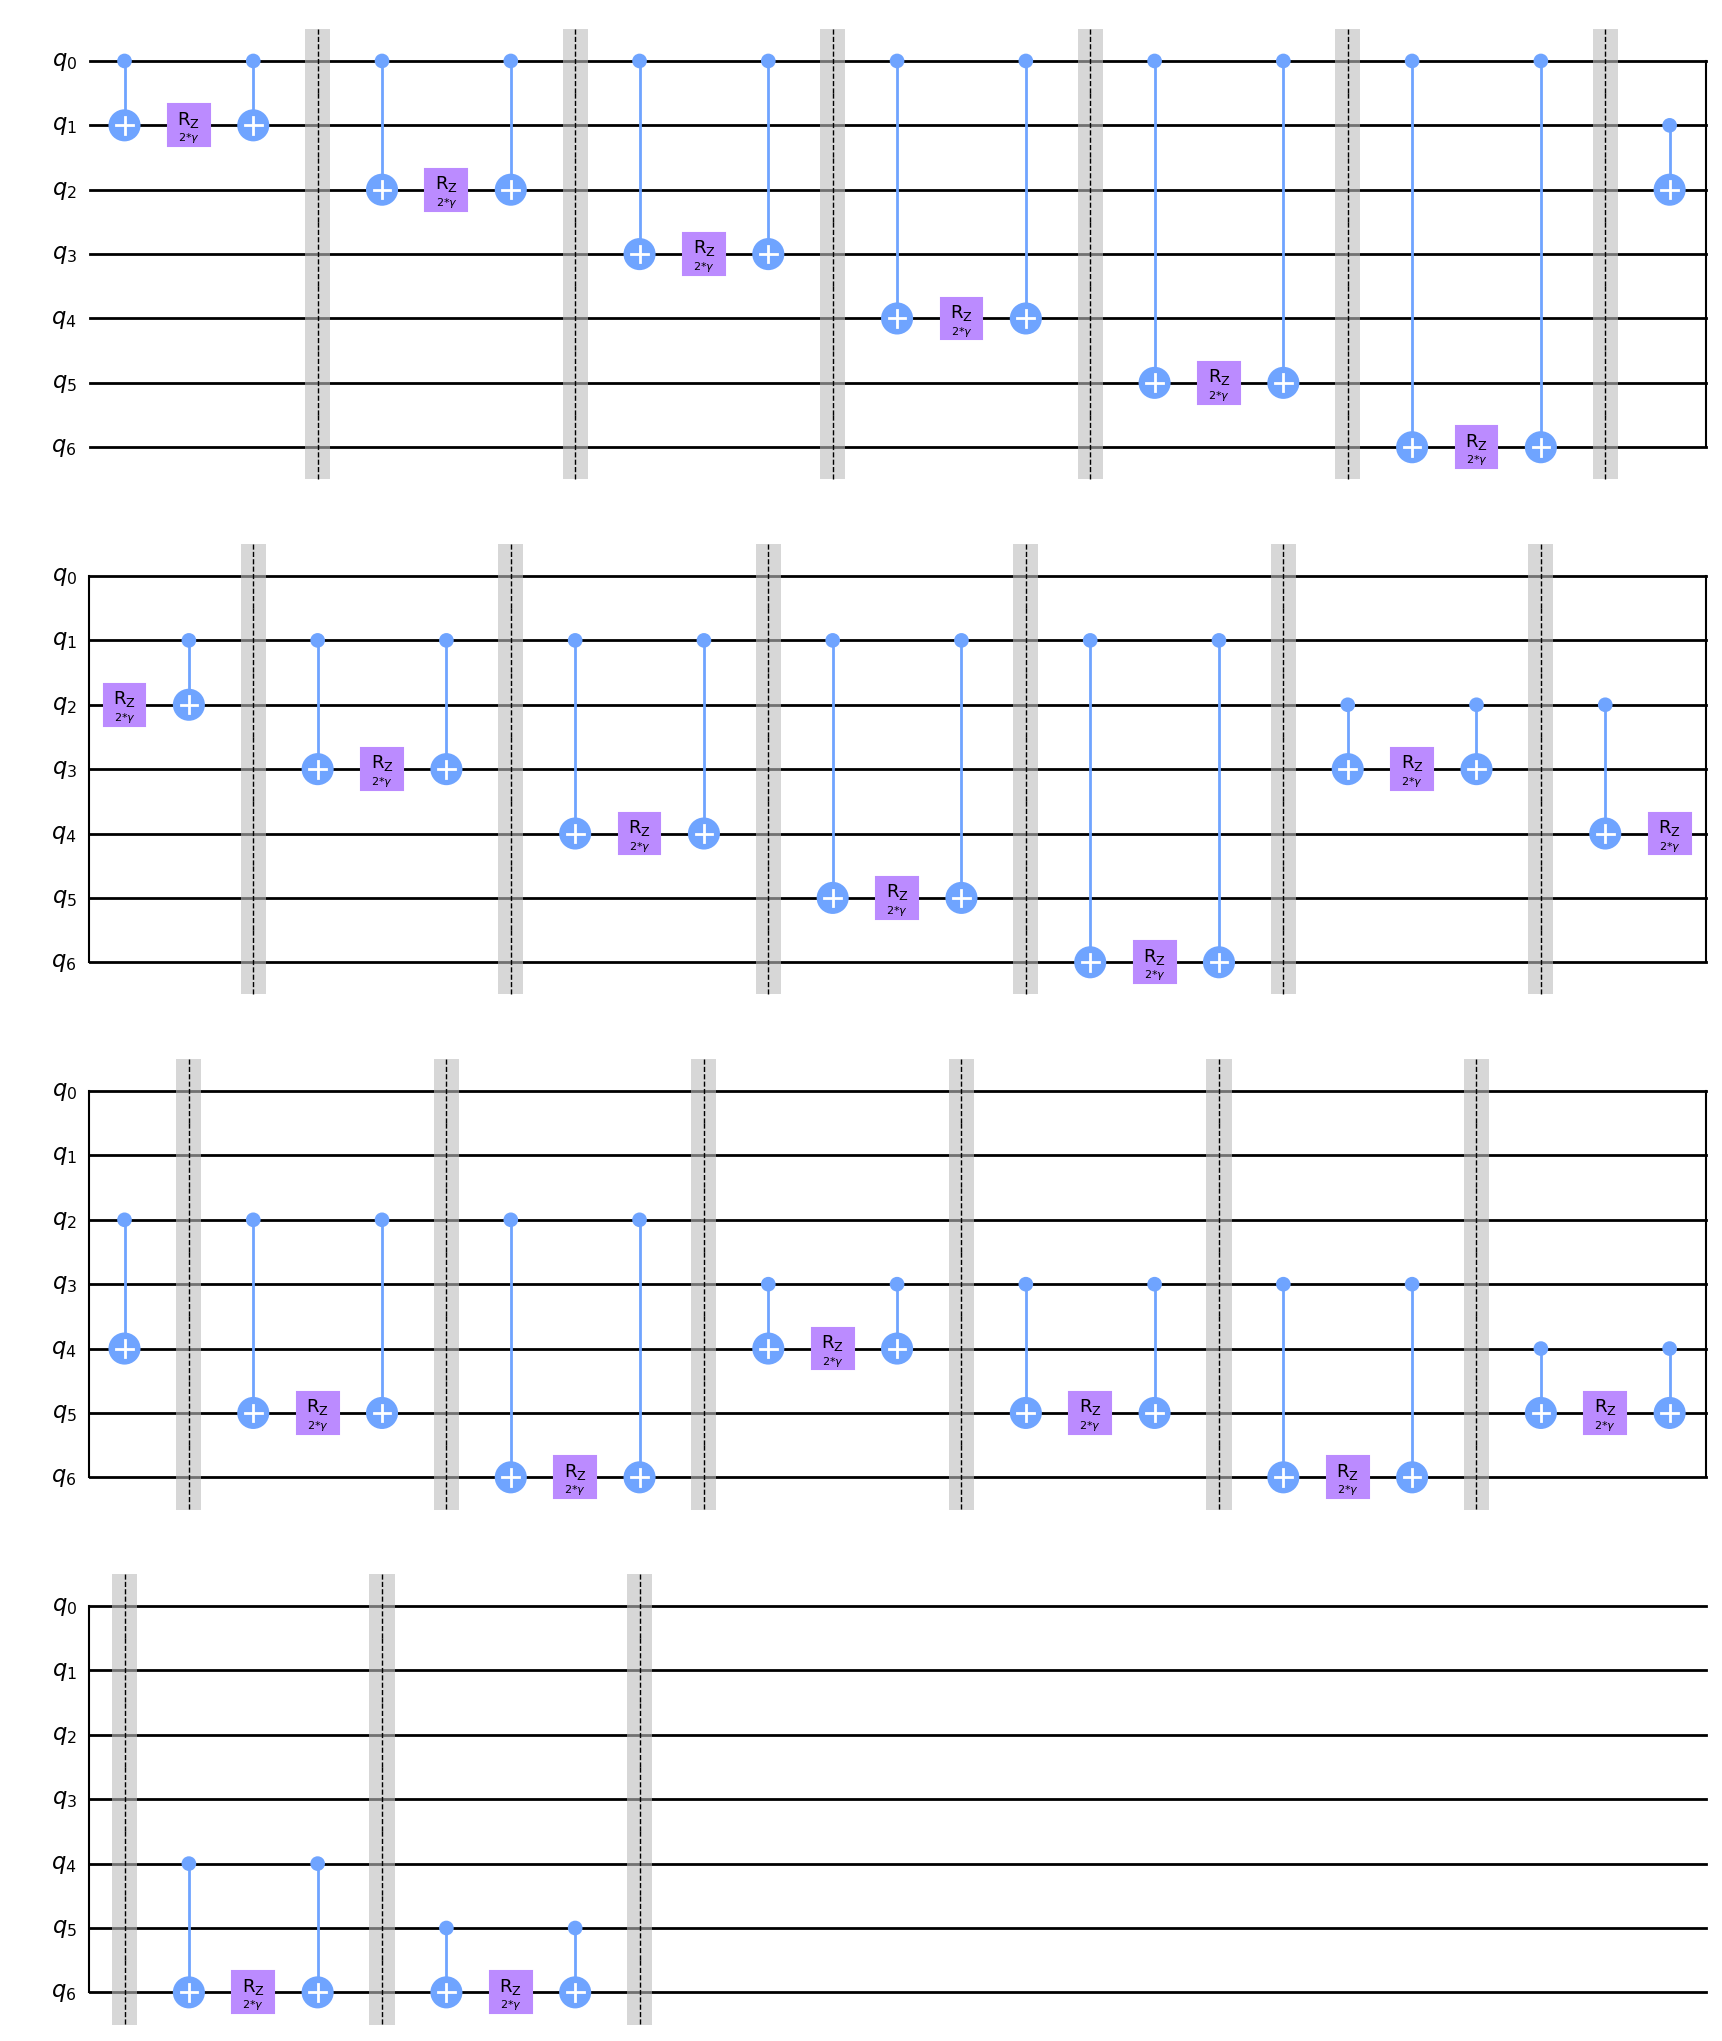

In [6]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw("mpl")

### The Mixing Unitary (Hamiltonian)

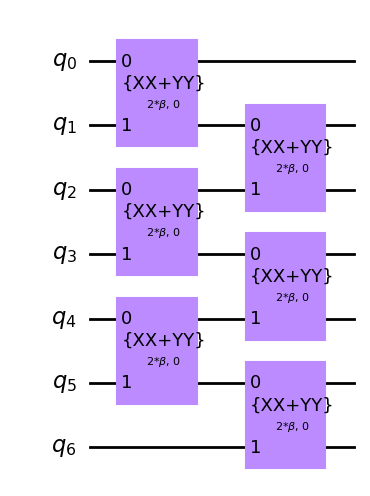

In [7]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
qc_mix = xy_mixer_parity(qc_mix, N_QUBITS, beta)
qc_mix.draw("mpl")

## Initial State

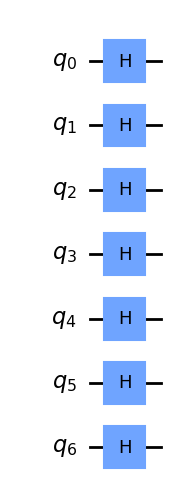

In [7]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw("mpl")

### The QAOA circuit

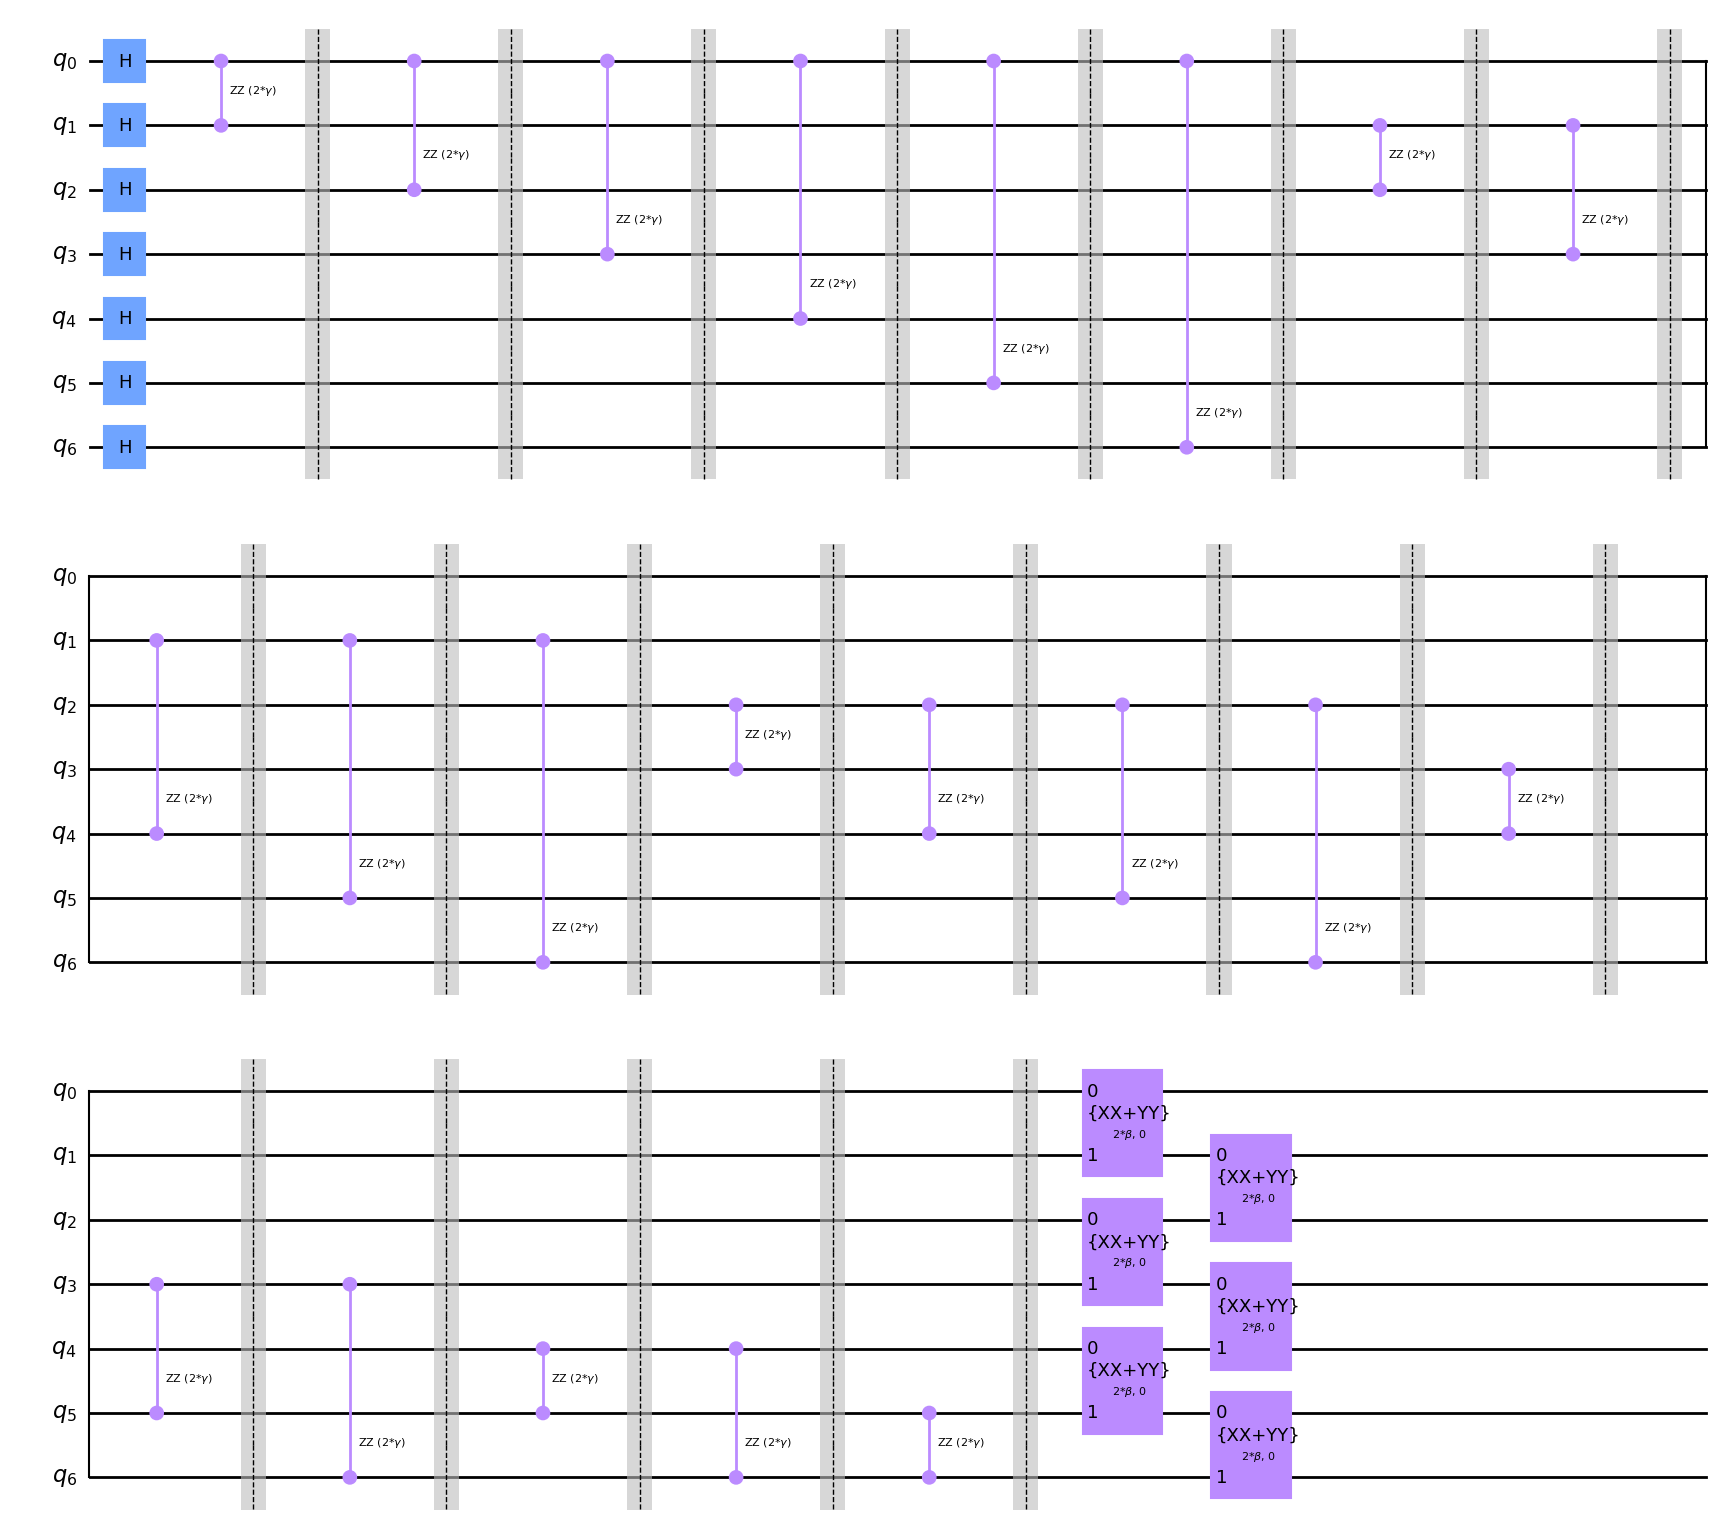

In [8]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

qc_qaoa.decompose().draw("mpl")

In [9]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, mixerStr, theta, no_meas=False):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        
        qc = get_mixer_from_string(mixerStr, qc, nqubits, beta[layer_index])
        
    if no_meas == False:
        qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, mixerStr, backendStr, shots):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    if backendStr == 'fakeM':
        backend = FakeMelbourneV2()
    else:
        backend = Aer.get_backend(backendStr)
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, mixerStr, theta)
        qc = transpile(qc, backend)
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -10.60546875
       x: [ 1.423e+00  1.045e+00]
    nfev: 29
   maxcv: 0.0


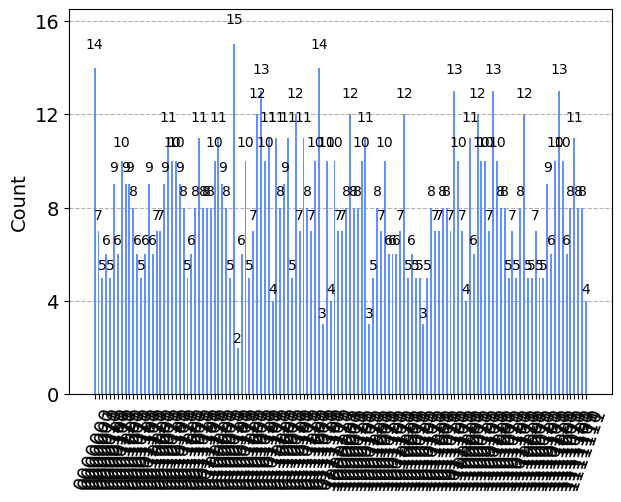

In [10]:
mixerStr = "x-mixer"
expectation = get_expectation(graph, mixerStr, backendStr, shots)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
print(res)
backend = Aer.get_backend(backendStr)
qc_res = create_qaoa_circ(graph, mixerStr, res.x)

counts = execute(qc_res, backend).result().get_counts()
plot_histogram(counts)

# Using Runtime 

In [11]:
"""
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
service = QiskitRuntimeService(channel='ibm_quantum')

backend = service.backends(simulator=True)[0]
print(backend)
options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[create_qaoa_circ(graph, theta, type="x_mixer"),create_qaoa_circ(graph, theta, type="xy_mixer_full"),create_qaoa_circ(graph, theta, type="xy_mixer_parity"),create_qaoa_circ(graph, theta, type="xy_mixer_ring")])
result = job.result()
result
"""

'\nfrom qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator\nservice = QiskitRuntimeService(channel=\'ibm_quantum\')\n\nbackend = service.backends(simulator=True)[0]\nprint(backend)\noptions = Options(simulator={"seed_simulator": 42}, resilience_level=0)\nwith Session(service=service, backend=backend):\n    sampler = Sampler(options=options)\n    job = sampler.run(circuits=[create_qaoa_circ(graph, theta, type="x_mixer"),create_qaoa_circ(graph, theta, type="xy_mixer_full"),create_qaoa_circ(graph, theta, type="xy_mixer_parity"),create_qaoa_circ(graph, theta, type="xy_mixer_ring")])\nresult = job.result()\nresult\n'

In [12]:
def get_function_values(gamma_values, beta_values, graph, mixer, backendStr, shots):
    # Initialize an array to store the function values
    fun_values = np.zeros((len(gamma_values), len(beta_values)))
    
    # Run the QAOA circuit for each pair of gamma and beta values
    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            theta = [beta, gamma]
            expectation = get_expectation(QAOA_Graph_Creator(graph), mixer, backendStr, shots)
            res = minimize(expectation, theta, method='COBYLA')
            fun_values[i, j] = res.fun
    return fun_values

In [13]:
# Detailed analysis: data for all cases
shots = 2048
problems = ["Standard", "Three-Regular", "SK"]
mixers = ["x_mixer", "xy_mixer_ring", "xy_mixer_parity", "xy_mixer_full"]

# Define the range of gamma and beta values
gamma_values = np.linspace(-1.5, 1.5, 10)
beta_values = np.linspace(-1.5, 1.5, 10)

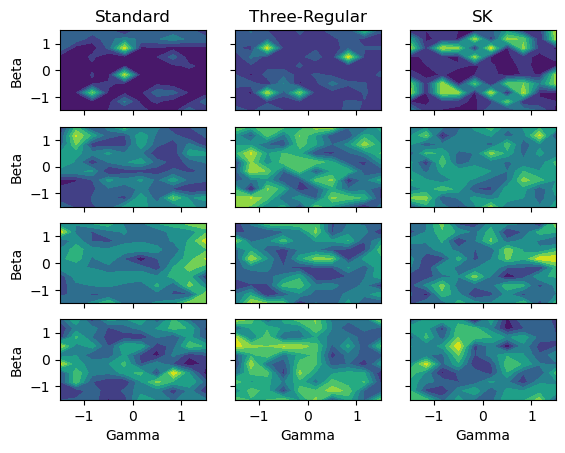

In [14]:
# Analysis with noise-free simulator
fig, axs = plt.subplots(4,3, sharex = True, sharey = True)
backendStr = 'qasm_simulator'

for i in range(len(mixers)):
    axs[i,0].set_ylabel('Beta')
    for j in range(len(problems)):
        values = get_function_values(gamma_values, beta_values, problems[j], mixers[i], backendStr, shots)
        axs[i,j].contourf(gamma_values, beta_values, values)
        axs[i,j].set_adjustable("box")
        #fig.colorbar(cs, label='Function value', ax=axs[0,2])
for i in range(len(problems)):
    axs[0,i].set_title(problems[i])
    axs[len(mixers)-1, i].set_xlabel('Gamma')
    
plt.show()

In [ ]:
# Analysis with noisy simulator
fig, axs = plt.subplots(4,3, sharex = True, sharey = True)
backendStr = 'fakeM'

for i in range(len(mixers)):
    axs[i,0].set_ylabel('Beta')
    for j in range(len(problems)):
        values = get_function_values(gamma_values, beta_values, problems[j], mixers[i], backendStr, shots)
        axs[i,j].contourf(gamma_values, beta_values, values)
        axs[i,j].set_adjustable("box")
        #fig.colorbar(cs, label='Function value', ax=axs[0,2])
for i in range(len(problems)):
    axs[0,i].set_title(problems[i])
    axs[len(mixers)-1, i].set_xlabel('Gamma')
    
plt.show()

In [16]:
# Computation of the circuit as a Statvector

def compute_expectation_sv(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    for bit_string, prob in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * prob
    return avg

def get_expectation_sv(theta, graph, mixerStr, backendStr, shots):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    if backendStr == 'fakeM':
        backend = FakeMelbourneV2()
    else:
        backend = Aer.get_backend(backendStr)
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, mixerStr, theta, no_meas=True)
        sv_result = Statevector(qc)
        sv = {}
        for i in range(2**qc.num_qubits):
            a = f"{bin(i)[2:]:0>{qc.num_qubits}}"
            sv[a] = np.abs(sv_result[i])**2
        return compute_expectation_sv(sv, graph)

    return execute_circ(theta)

def get_function_values_sv(gamma_values, beta_values, graph, mixer, backendStr, shots):
    # Initialize an array to store the function values
    fun_values = np.zeros((len(gamma_values), len(beta_values)))
    
    # Run the QAOA circuit for each pair of gamma and beta values
    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            theta = [beta, gamma]
            expectation = get_expectation_sv(theta, QAOA_Graph_Creator(graph), mixer, backendStr, shots)
            fun_values[i, j] = expectation
    return fun_values

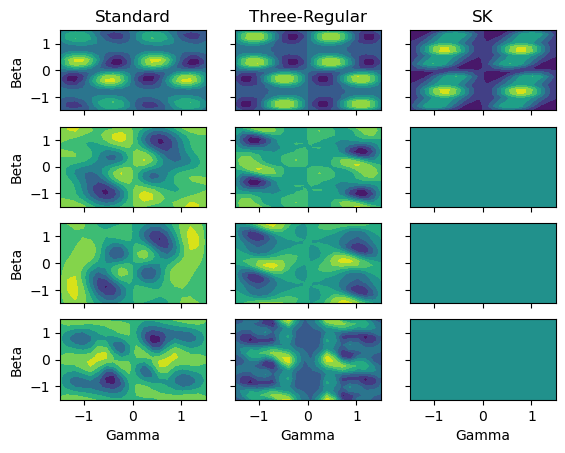

In [18]:
# Create the contour plot with the circuit as a Statvector
fig, axs = plt.subplots(4,3, sharex = True, sharey = True)


# Define the range of gamma and beta values - more than before for finer/better results
gamma_values = np.linspace(-1.5, 1.5, 20)
beta_values = np.linspace(-1.5, 1.5, 20)

for i in range(len(mixers)):
    axs[i,0].set_ylabel('Beta')
    for j in range(len(problems)):
        values = get_function_values_sv(gamma_values, beta_values, problems[j], mixers[i], backendStr, shots)
        axs[i,j].contourf(gamma_values, beta_values, values)
        axs[i,j].set_adjustable("box")
        #fig.colorbar(cs, label='Function value', ax=axs[0,2])
for i in range(len(problems)):
    axs[0,i].set_title(problems[i])
    axs[len(mixers)-1, i].set_xlabel('Gamma')
    
plt.show()

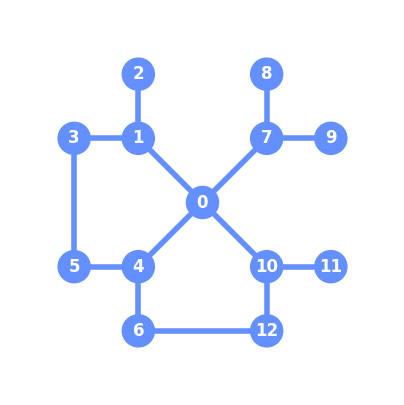

In [8]:
# Reduction the depth of a XY mixer

num_qubits = 13
qubit_coordinates = [[2, 2], [1, 1], [0, 1], [1, 0], [3, 1], [3, 0], [4, 1], [1, 3], [0, 3], [1, 4], [3, 3], [3, 4], [4, 3]]
coupling_map = [(0,1),(1,2),(1,3),(0,4),(4,5),(4,6),(3,5),(0,10),(10,11),(10,12),(6,12),(0,7),(7,9),(7,8)]
plot_coupling_map(num_qubits, qubit_coordinates, coupling_map)

In [9]:
def find_sub_group(coupling_map, color=False):
    # Initialize the step of each edge to None
    steps = {edge: None for edge in coupling_map}
    # Sort the coupling_map by their first node
    sorted_coupling_map = sorted(coupling_map)
    # Assign steps
    for edge in sorted_coupling_map:
        # Find the steps of the adjacent coupling_map
        adjacent_steps = {steps[e] for e in sorted_coupling_map if e != edge and (e[0] == edge[0] or e[1] == edge[0] or e[0] == edge[1] or e[1] == edge[1])}
        # Assign the smallest step that is not in adjacent_steps
        step = 0
        while step in adjacent_steps:
            step += 1
        steps[edge] = step
    # The number of steps is the maximum step plus one
    num_steps = max(steps.values()) + 1
    grouped_map = [[] for i in range(num_steps)]
    for edge, step in steps.items():
        grouped_map[step].append(edge)
    color_list = []
    c = [[random.random() for i in range(4)] for j in range(num_steps)]
    for edge in coupling_map:
        color_list.append(c[steps[edge]])
    if color == False:
        return grouped_map
    if color == True:
        return grouped_map, color_list

grouped_map, color_list = find_sub_group(coupling_map, color=True)
print("the depth is", len(grouped_map))

the depth is 4


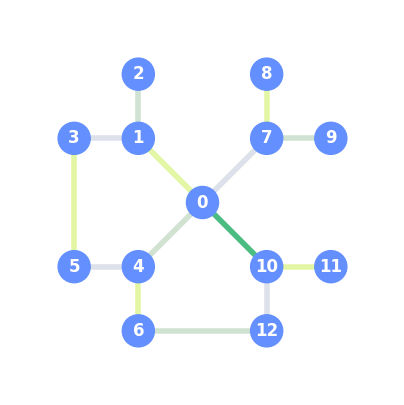

In [10]:
num_qubits = 13
qubit_coordinates = [[2, 2], [1, 1], [0, 1], [1, 0], [3, 1], [3, 0], [4, 1], [1, 3], [0, 3], [1, 4], [3, 3], [3, 4], [4, 3]]
coupling_map = [(0,1),(1,2),(1,3),(0,4),(4,5),(4,6),(3,5),(0,10),(10,11),(10,12),(6,12),(0,7),(7,9),(7,8)]
plot_coupling_map(num_qubits, qubit_coordinates, coupling_map, line_color=color_list)

the depth is 4


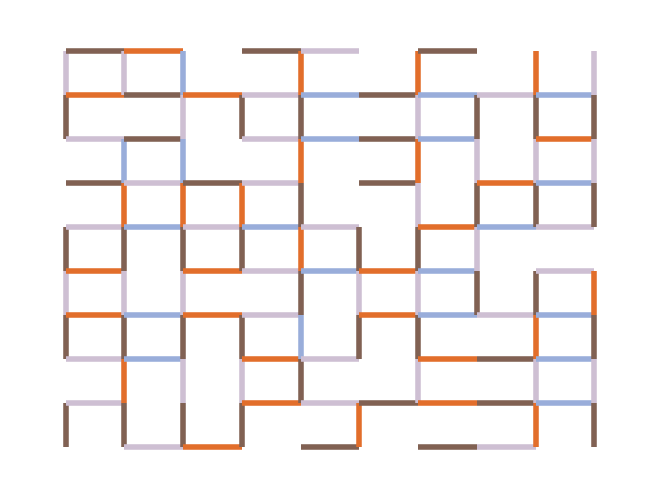

In [11]:


# Number of nodes (spins) in the SK model
num_nodes = 64

rows = 10
columns = 10


def generate_lattice_with_defects(rows, columns, defect_probability):
    G = nx.Graph()

    # Create nodes
    for i in range(rows):
        for j in range(columns):
            node_id = i * columns + j
            G.add_node(node_id)

    # Connect nodes with lattice structure
    for i in range(rows):
        for j in range(columns):
            node_id = i * columns + j

            # Connect to the right neighbor
            if j < columns - 1:
                G.add_edge(node_id, node_id + 1)

            # Connect to the bottom neighbor
            if i < rows - 1:
                G.add_edge(node_id, node_id + columns)

    # Introduce defects
    for edge in list(G.edges()):
        if random.random() < defect_probability:
            G.remove_edge(*edge)

    return G


# Generate a 5x5 lattice graph with defects
graph = generate_lattice_with_defects(rows, columns, 0.2)
edges = graph.edges()
grouped_map, color_list = find_sub_group(edges, color=True)
pos = {i * rows + j: [i, j] for i in range(rows) for j in range(columns)}

# Draw the graph
print("the depth is", len(grouped_map))
nx.draw(graph, alpha=1, width=4, node_size=0, edge_color=color_list, pos=pos)

the depth is 15


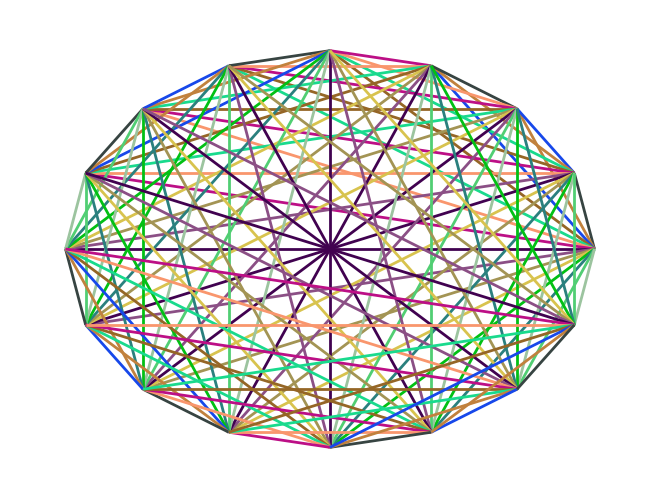

In [12]:
graph = nx.complete_graph(16)
edges = graph.edges()
grouped_map, color_list = find_sub_group(edges, color=True)
pos = nx.circular_layout(graph)

# Draw the graph
print("the depth is", len(grouped_map))
nx.draw(graph, alpha=1, width=2, node_size=0, edge_color=color_list, pos=pos)